<div style="height:100px">
    <div style="float: left"><img src='../images/osr-logo.png' width=150px /></div>
    <div style="float: left; margin-left:30px"><span style="font-weight: normal; font-size: 30pt; color:#666666">密码工程实验指引</span></div>
    <img src='../images/osr-line.jpg' style="width:100%; height: 5px" />
</div>


# 软件AES侧信道攻击

## 实验目的

通过实验，掌握对AES软件实现的CPA攻击方法，了解侧信道攻击的基本步骤。

## 实验要求

- 使用python [scared](https://github.com/eshard/scared) 库对软件AES成功实施CPA攻击，恢复密钥。

## 实验环境需求

- **硬件需求**
    + OSR-Mega2560 或 OSR-407开发板
    + Pico 3206D示波器
- **软件需求**
    + Arduino IDE
    + osrtoolkit平台
    + python scared库

## 实验内容

### CPA原理

侧信道基本的模型假设如下图所示：

<img src="../images/侧信道攻击模型.png" width=700px>

攻击者监听密码算法运行泄露的侧信道信息（如功耗泄露）和通信信道信息（如明密文等），利用适当的模型和统计工具，建立密钥的区分器，对正确密钥进行恢复。

相关能量攻击（CPA）是最常使用的一种攻击手段，利用相关性构建密钥区分器。其工作原理如下图所示：

<img src="../images/CPA.png" width=600px>

<img src="../images/cpa2.png" width=800px>

### 软件AES攻击示例

我们已经能够在微控制器上运行AES的软件实现，在之前的配置中，微控制器可以通过串口助手或python pyserial库接收明文，对其进行加密，并返回相应的密文。作为设备的攻击者，可获得明文和对应的密文。

我们采用CPA攻击方法攻击AES的软件实现，该方法包括5个步骤：

1. 选择所执行算法的某个中间值；

2. 测量能量消耗；

3. 计算假设中间值；

4. 将中间值映射为能量消耗值；

5. 比较假设能量消耗值和能量迹。

在具体的攻击中，我们决定选择第一轮中AES经过字节代换(SubByte)后的输出，该中间值是明文和密钥的函数。
选择了这个中间值后，我们使用osrtoolkit采集平台记录了在AES第一轮执行期间，微处理器加密1000个不同明文时的能量消耗。
然后可以直接使用python scared库中的CPA分析工具去恢复密钥。

### 参考文献

1. [Correlation power analysis with a leakage model.](../docs/CPA.pdf)

## 实验过程

In [1]:
from osrtoolkit.oscilloscope import Pico3000
from osrtoolkit.trace import ETSStorer

In [2]:
pico = Pico3000()  # 声明pico示波器对象
pico.form  # 打开pico示波器配置界面

### 对AES软件实现实施CPA攻击

#### 导入eshard的scared库

In [3]:
import scared
from scared import aes
import matplotlib.pyplot as plt
import numpy as np

#### 定义一个选择函数，对于所有可能的密钥假设，计算第一轮字节代换(SubByte)后输出的中间值。

In [4]:
S = aes.selection_functions.encrypt.FirstSubBytes()
key = bytes([0x00, 0x00, 0x00, 0x00,
    0x00, 0x00, 0x00, 0x00,
    0x00, 0x00, 0x00, 0x00,
    0x00, 0x00, 0x00, 0x00,])

#### 建立一个CPA攻击对象，参数包括选择函数，泄露模型以及判别函数。

In [5]:
a = scared.CPAAttack(
        selection_function=S,
        model=scared.HammingWeight(),
        discriminant=scared.maxabs)

#### 攻击之前，需要一个能量迹容器将我们的TraceHeaderSet数据封装起来，同时指定攻击范围。

In [6]:
# 补充轨迹文件名称
ths = scared.traces.read_ths_from_ets_file('store.ets')

In [7]:
container = scared.Container(ths)

#### 执行攻击

In [9]:
a.run(container)

In [10]:
a.results.shape

(256, 16, 50000)

a.results 提供计算结果，包含每一个可能的假设密钥（16个字节，每个字节有256种可能）对应的假设能量消耗值与在每一个位置记录的能量迹之间的相关系数。

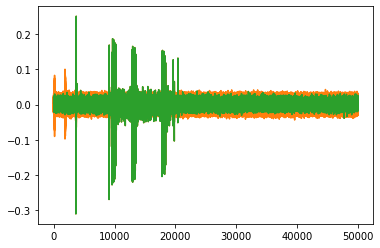

In [11]:
plt.plot(a.results[:,0, :].T, 'C1')
plt.plot(a.results[key[0], 0, :], 'C2')
plt.show()

上图显示，考虑密钥的第一个字节，当密钥假设为正确密钥值时，对应的相关性系数是所有密钥假设相关系数的最大值。

#### 判断最佳候选密钥与软件AES所使用的密钥是否相等。

In [12]:
cpa_first_round_key = np.argmax(a.scores, axis=0) 
np.array_equal(bytearray(key), cpa_first_round_key)

True

In [13]:
cpa_first_round_key

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

a.scores 给出表现最好的候选密钥。

攻击结果表明，我们对软件AES成功地实施了CPA攻击，恢复出正确密钥。